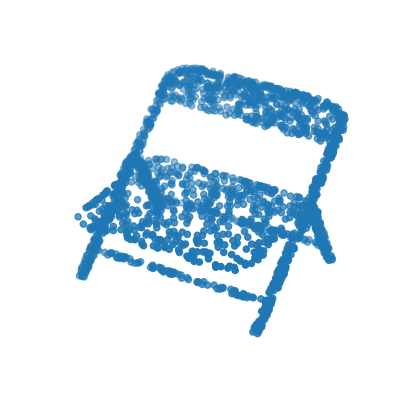

processing class: table
[[ -5.06181454   0.96628738   6.88975   ]
 [  8.85825    -10.6775962   -3.47287002]
 [  8.85825    -10.31339849   2.90562249]
 ...
 [ -0.30324647   1.57499149   8.85825   ]
 [ -9.30726875 -10.8265       1.48858437]
 [ -8.85825     -9.18085345  -3.21094302]]
<class 'trimesh.caching.TrackedArray'>
[[ -9.33768302  -3.16215988  12.75      ]
 [-11.6263963    1.36816044  14.25      ]
 [  7.34313348  -7.53938828  14.25      ]
 ...
 [ -0.4105439   -7.34205855 -14.25      ]
 [ 13.17479439   0.63457102  14.25      ]
 [ -4.79920528  15.36389229  12.75      ]]
<class 'trimesh.caching.TrackedArray'>
[[ 10.85246487 -11.45934055   7.182925  ]
 [ 17.56433235 -17.398165    -1.22619599]
 [ -9.54576714   1.97886624  -1.478455  ]
 ...
 [ 12.61890731  18.0064484    5.752824  ]
 [-10.14714427  10.20994003   6.986124  ]
 [-16.04913883   3.91569777   7.182925  ]]
<class 'trimesh.caching.TrackedArray'>
[[ 5.31602563 -5.85947612  9.625     ]
 [-2.91026377 10.17101357 11.125     ]
 [ 5.64

KeyboardInterrupt: 

In [9]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

"""
## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:
"""

DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

"""
We can use the `trimesh` package to read and visualize the `.off` mesh files.
"""

mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

"""
To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.
"""

points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

"""
To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.
"""


def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            kk = trimesh.load(f).sample(num_points)
            #print(kk)
            #print(type(kk))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )


"""
Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.
"""

NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

"""
Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.
"""


def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
print(len(train_points))
print(type(train_points))
print((train_points))

In [ ]:
print(type(train_points[0]))
print(len(train_points[0]))
print((train_points[0]))

In [ ]:
print(len(train_labels))
print(type(train_labels))
print((train_labels))